# Inferring distance from parallax

The point of this notebook is to see how to rigorously infer distances from measured parallaxes, using a Bayesian approach. The naive way of estimating distance from a measured parallax ($r = \frac{1}{\hat{\varpi}}$), where $\hat{\varpi}$ is the measured parallax, performs poorly when the measurement uncertainties are large, and breaks down entirely when $\hat{\varpi} < 0$.

For more on this topic, see [Bailer-Jones (2015)](https://ui.adsabs.harvard.edu/abs/2015PASP..127..994B/abstract).

First, we make sure that the [`emcee` package](https://emcee.readthedocs.io/en/stable/) (for MCMC sampling) and the `corner` package (for making corner plots of Markov Chains) are installed:

In [ ]:
! pip install emcee corner

Then, we load the necessary modules:

In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from scipy.interpolate import interp1d
from scipy.optimize import minimize

import emcee
import corner

# Inferring the distance of a single source

## Likelihood

We observe a parallax of $\hat{\varpi}$, with measurement uncertainty $\sigma_{\varpi}$. Given a true distance $r$, the likelihood is given by
$$
  p \left( \hat{\varpi} \mid r, \sigma_{\varpi} \right)
  =
  \frac{1}{\sqrt{2\pi \sigma_{\varpi}^2}}
  \,
  \exp \left[
    -\frac{1}{2} \left(
      \frac{
        \hat{\varpi} - \frac{1 \,\mathrm{mas}\,\mathrm{kpc}}{r}
      }{\sigma_{\varpi}}
    \right)^{\!\! 2}
    \,
  \right]
  \, .
$$

In [3]:
def likelihood(plx_obs, r, sigma_plx):
    plx_true = 1/r
    norm = np.sqrt(2*np.pi)*sigma_plx
    return np.exp(-0.5 * ((plx_obs - plx_true)/sigma_plx)**2) / norm

## Uniform prior

First, let's consider a uniform (constant) prior between 0 and $r_{\mathrm{max}}$:
$$
p \left( r \right) =
  \begin{cases}
    \frac{1}{r_{\mathrm{max}}} & 0 < r < r_{\mathrm{max}} \\
    0 & \mathrm{otherwise}
  \end{cases}
  \, .
$$

In [4]:
def uniform_prior(r, r_max):
    return np.heaviside(r_max-r, 0) / r_max

The posterior is given by
$$
  p \left( r \mid \hat{\varpi}, \sigma_{\varpi} \right)
  =
  \frac{1}{\mathcal{Z}} \, 
  p \left( \hat{\varpi} \mid r, \sigma_{\varpi} \right) p \left( r \right) \, ,
$$
where $\mathcal{Z}$ is a normalizing constant that does not depend on $r$. We'll leave out all normalizing factors that do not depend on $r$, and just focus on the *shape* of the posterior on $r$.

We'll assume here that $\hat{\varpi} = 1$ and $r_{\mathrm{max}} = 4$ (in any matching set of angle and distance units, such as mas and kpc), and plot the posterior for different values of $\sigma_{\varpi}$:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


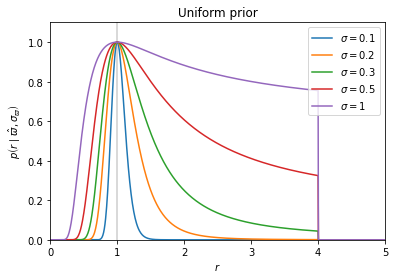

In [5]:
r_range = np.linspace(0, 5, 1000)

plt.axvline(1, c='k', alpha=0.2)

for sigma in [0.1, 0.2, 0.3, 0.5, 1]:
    posterior = likelihood(1, r_range, sigma) * uniform_prior(r_range, 4)
    
    # Normalize peak of each posterior to 1, just to show shape more clearly
    posterior /= np.max(posterior)

    plt.plot(r_range, posterior, label=rf'$\sigma = {sigma}$')

plt.legend()

plt.xlabel(r'$r$')
plt.ylabel(r'$p \left( r \mid \hat{\varpi}, \sigma_{\varpi} \right)$')

plt.xlim(0, 5)
plt.ylim(0, 1.1)

plt.title('Uniform prior')

plt.show()

## Density prior

Next, let's consider a prior that encodes a density $\rho \left( r \right)$ along the line of sight:
$$
p \left( r \right) \propto
  \begin{cases}
    r^2 \rho \left( r \right) & r > 0 \\
    0 & r \leq 0
  \end{cases}
  \, .
$$
Recall that the $r^2$ factor has to do with the fact that there's more volume (per unit solid angle and distance) farther away: $\mathrm{d}V = r^2 \mathrm{d}r \mathrm{d}\Omega$.

First, we'll implement a uniform density prior:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


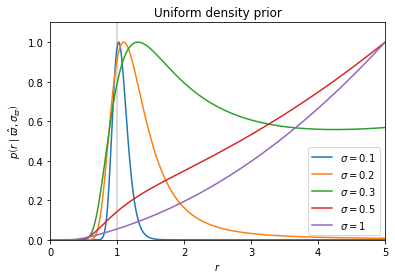

In [6]:
r_range = np.linspace(0, 5, 1000)

plt.axvline(1, c='k', alpha=0.2)

for sigma in [0.1, 0.2, 0.3, 0.5, 1]:
    posterior = likelihood(1, r_range, sigma) * r_range**2

    # Normalize peak of each posterior to 1, just to show shape more clearly
    posterior /= np.max(posterior)
    
    plt.plot(r_range, posterior, label=rf'$\sigma = {sigma}$')

plt.legend()

plt.xlabel(r'$r$')
plt.ylabel(r'$p \left( r \mid \hat{\varpi}, \sigma_{\varpi} \right)$')

plt.xlim(0, 5)
plt.ylim(0, 1.1)

plt.title('Uniform density prior')

plt.show()

Next, we'll implement an exponentially falling density prior, with a scale length of $L = 1$:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


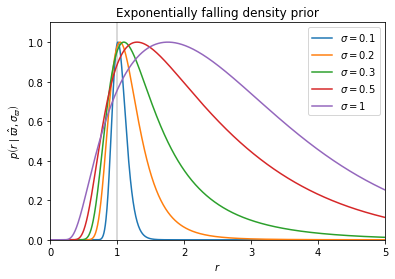

In [7]:
r_range = np.linspace(0, 5, 1000)

plt.axvline(1, c='k', alpha=0.2)

L = 1

for sigma in [0.1, 0.2, 0.3, 0.5, 1]:
    prior = r_range**2 * np.exp(-r_range/L)
    posterior = likelihood(1, r_range, sigma) * prior

    # Normalize peak of each posterior to 1, just to show shape more clearly
    posterior /= np.max(posterior)
    
    plt.plot(r_range, posterior, label=rf'$\sigma = {sigma}$')

plt.legend()

plt.xlabel(r'$r$')
plt.ylabel(r'$p \left( r \mid \hat{\varpi}, \sigma_{\varpi} \right)$')

plt.xlim(0, r_range[-1])
plt.ylim(0, 1.1)

plt.title('Exponentially falling density prior')

plt.show()

With this prior, it is possible to get multimodal posteriors. Here is an example with $L = 15$:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


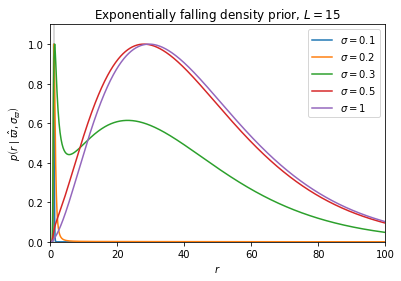

In [8]:
r_range = np.linspace(0, 100, 1000)

plt.axvline(1, c='k', alpha=0.2)

L = 15

for sigma in [0.1, 0.2, 0.3, 0.5, 1]:
    prior = r_range**2 * np.exp(-r_range/L)
    posterior = likelihood(1, r_range, sigma) * prior

    # Normalize peak of each posterior to 1, just to show shape more clearly
    posterior /= np.max(posterior)
    
    plt.plot(r_range, posterior, label=rf'$\sigma = {sigma}$')

plt.legend()

plt.xlabel(r'$r$')
plt.ylabel(r'$p \left( r \mid \hat{\varpi}, \sigma_{\varpi} \right)$')

plt.xlim(0, r_range[-1])
plt.ylim(0, 1.1)

plt.title(f'Exponentially falling density prior, $L = {L}$')

plt.show()

## Next step

Investigate how these priors behave when the measured parallax is *negative*. This sometimes happens for real parallax measurements, because measurement noise can scatter parallaxes negative. Does the posterior behave reasonably for any choice of prior?

# Inferring distances of population of sources

Now, we build a hierarchical model for the distribution of sources, in which the scale length $L$ is a model parameter that can vary. We will put a prior on $L$, and then simultaneously infer $L$ and the distances to a set of sources.

We'll make $\ln L$ our variable, and we'll put a uniform prior on it:
$$
  p \left( \ln L \right) =
  \begin{cases}
    1 & \ln L_0 < \ln L < \ln L_1 \\
    0 & \mathrm{otherwise}
  \end{cases}
  \, .
$$
This is not necessarily the best prior to choose, and you can explore the effect of other priors.

## Generate mock data

The first step is to draw mock data from our priors. We'll draw $\ln L$ first, and then draw $\left\{ r \right\}$ given our value of $\ln L$:

In [11]:
rng = np.random.default_rng() # Random number generator

# Limits on ln(L)
ln_L0 = -2 #@param {type:"number"}
ln_L1 = 2 #@param {type:"number"}

n_sources =  25#@param {type:"integer"}

L_true = np.exp(rng.uniform(ln_L0, ln_L1))

print(f'Drew L_true = {L_true} (ln L_true = {np.log(L_true)})')

# Cumulative distribution of r/L
cumulative_prob = lambda r_over_L: 0.5 * (2 - np.exp(-r_over_L) * (r_over_L**2 + 2*r_over_L + 2))
# Construct inverse function of the cumulative distribution using an interpolator
r_range = np.linspace(0, 100*L_true, 10000)
r_of_P = interp1d(cumulative_prob(r_range/L_true), r_range)
# Draw r using the inverse cumulative distribution function
r_true = r_of_P(rng.uniform(0, 1, size=n_sources))

Drew L_true = 3.7564314198684685 (ln L_true = 1.3234694162697638)


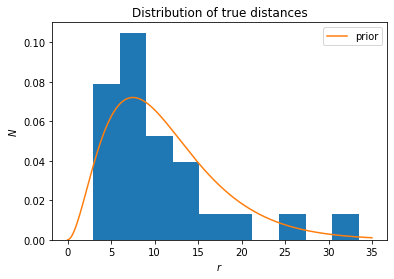

In [12]:
plt.hist(r_true, density=True)

r_range = np.linspace(0, plt.xlim()[1], 1000)
plt.plot(
    r_range,
    0.5 * r_range**2 * np.exp(-r_range/L_true) / L_true**3,
    label='prior'
)

plt.xlabel('$r$')
plt.ylabel('$N$')

plt.legend()

plt.title('Distribution of true distances')

plt.show()

We'll generate mock observed parallaxes, by adding in Gaussian noise to the true parallaxes:

In [13]:
sigma_plx_scale = 0.1 #@param {type:"number"}

# Draw the sigmas from an exponential distribution with the given scale
sigma_plx = np.random.exponential(sigma_plx_scale, size=n_sources)

# Generate the observed parallaxes by adding in Gaussian noise
plx_obs = 1/r_true + sigma_plx * rng.standard_normal(n_sources)

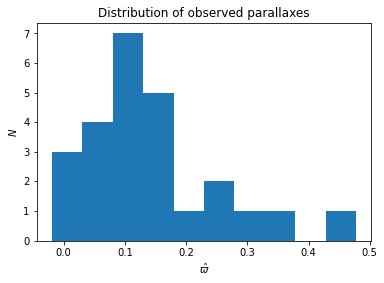

In [14]:
plt.hist(plx_obs)
plt.xlabel(r'$\hat{\varpi}$')
plt.ylabel('$N$')
plt.title('Distribution of observed parallaxes')
plt.show()

## Implement the posterior distribution function

Now, we'll implement the posterior distribution on $\ln L$ and $\left\{ \ln r \right\}$ that we derived in class. The prior on $r$, conditional on $L$, is given by:
$$
  \ln p \left( r \mid L \right) = 2 \ln r - \frac{r}{L} - 3 \ln L \, .
$$
The prior on $L$ and the likelihood for each $r$ have already been described above.

In [15]:
prior_lnL = lambda lnL: (np.array((lnL > ln_L0) & (lnL < ln_L1))).astype('f8')
ln_prior_r = lambda lnr, lnL: 2*lnr - np.exp(lnr-lnL) - 3*lnL
ln_likelihood_r = lambda r, plx_obs, sigma_plx: -0.5 * ((plx_obs - 1/r) / sigma_plx)**2

def ln_posterior(lnr, lnL, plx_obs, sigma_plx):
    r = np.exp(lnr)
    ln_prior = np.log(prior_lnL(lnL)) + np.sum(lnr + ln_prior_r(lnr, lnL))
    ln_like = np.sum(ln_likelihood_r(r, plx_obs, sigma_plx))
    return ln_prior + ln_like

To check that we've implemented these functions correctly, we'll plot the posterior distribution as a function of $\ln L$, holding $\left\{ \ln r \right\}$ to their true values. We should see a peak near the correct value of $\ln L$:

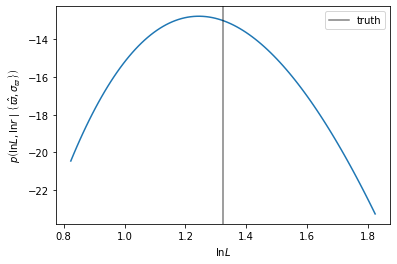

In [21]:
lnL_range = np.linspace(np.log(L_true)-0.5, np.log(L_true)+0.5, 100)
lnp_range = [ln_posterior(np.log(r_true), lnL, plx_obs, sigma_plx) for lnL in lnL_range]
plt.plot(lnL_range, lnp_range)
plt.axvline(np.log(L_true), c='k', alpha=0.5, label='truth')
plt.xlabel(r'$\ln L$')
plt.ylabel(r'$p \left( \ln L, \ln r \mid \left\{ \hat{\varpi}, \sigma_{\varpi} \right\} \right)$')
plt.legend()
plt.show()

Now, we check that if we hold $\ln L$ at its true value, and shift all of the values of $\ln r$ by some $\Delta \ln r$, that the posterior peaks for $\Delta \ln r \sim 0$:

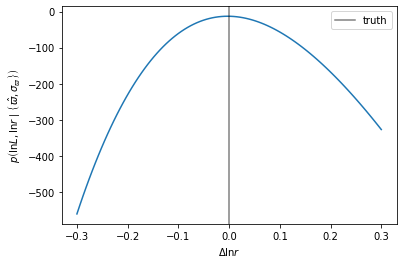

In [22]:
dlnr_range = np.linspace(-0.3, 0.3, 100)
lnp_range = [ln_posterior(np.log(r_true)+dlnr, np.log(L_true), plx_obs, sigma_plx) for dlnr in dlnr_range]
plt.plot(dlnr_range, lnp_range)
plt.axvline(0, c='k', alpha=0.5, label='truth')
plt.xlabel(r'$\Delta \ln r$')
plt.ylabel(r'$p \left( \ln L, \ln r \mid \left\{ \hat{\varpi}, \sigma_{\varpi} \right\} \right)$')
plt.legend()
plt.show()

## Find maximum of posterior distribution

To run MCMC, we have to give a starting guess. This is a high-dimensional problem, so if we give a bad initial guess, the sampler might take a very long time to find a reasonable region of parameter space.

Therefore, before we sample, we'll use an optimizer to find the maximum of the posterior density function. We'll begin with a completely random guess, and then alternate between optimizing $\ln L$ and optimizing $\left\{ \ln r \right\}$:

In [23]:
lnr_opt = rng.normal(size=n_sources)
lnL_opt = rng.uniform(ln_L0, ln_L1)

for i in range(5):
    # Optimize ln(L), holding {ln(r)} fixed
    res = minimize(lambda x: -ln_posterior(x, lnL_opt, plx_obs, sigma_plx), lnr_opt)
    lnr_opt = res.x
    # Optimize {ln(r)}, holding ln(L) fixed
    res = minimize(lambda x: -ln_posterior(lnr_opt, x, plx_obs, sigma_plx), lnL_opt)
    lnL_opt = res.x

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
/usr/local/lib/python3.7/dist-packages/scipy/optimize/optimize.py:697: RuntimeWarning: invalid value encountered in subtract
  df = (f(*((xk + d,) + args)) - f0) / d[k]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


In [24]:
print(f'lnL_opt = {float(lnL_opt):.5f} (lnL_true = {np.log(L_true):.5f})')

lnL_opt = 1.04113 (lnL_true = 1.32347)


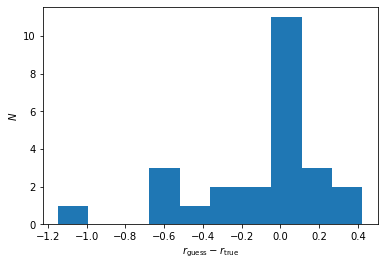

In [26]:
plt.hist(lnr_opt - np.log(r_true))
plt.xlabel(r'$r_{\mathrm{guess}} - r_{\mathrm{true}}$')
plt.ylabel(r'$N$')
plt.show()

## Use MCMC to sample from posterior distribution

Now, we set up the MCMC sampler. For the default algorithm used by `emcee`, we have to specify how many "walkers" to use. This should be some multiple of the number of dimensions (the algorithm does not work if there are fewer walkers than dimensions):

In [28]:
multiple = 5 #@param {type:"integer"}

n_dim = n_sources + 1
n_walkers = multiple * n_dim

# emcee wants a function that takes all of the parameters as one array,
# and which then outputs ln(posterior). We pack (ln(L), {ln(r)}) into one
# array, which we call theta.
def ln_prob_fn(theta):
    lnL = theta[0]
    lnr = theta[1:]
    return ln_posterior(lnr, lnL, plx_obs, sigma_plx)

sampler = emcee.EnsembleSampler(n_walkers, n_dim, ln_prob_fn)

We use the optimal values of $\ln L$ and $\left\{ \ln r \right\}$ - plus some Gaussian noise - as the starting point for our MCMC walkers:

In [29]:
theta_guess = np.hstack([lnL_opt, lnr_opt])
theta_guess = theta_guess[None,:] + 0.01 * rng.normal(size=(n_walkers,n_dim))

We let the MCMC sampler "burn in":

In [46]:
n_burn_in = 1000 #@param {type:"integer"}
state = sampler.run_mcmc(theta_guess, n_burn_in, store=False, progress=True)
sampler.reset()

  2%|▏         | 18/1000 [00:00<00:05, 174.75it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
100%|██████████| 1000/1000 [00:06<00:00, 156.20it/s]


Then we keep taking steps to generate samples. The `thin` parameter tells `emcee` how often to save a sample from the chain. With `thin = 20`, it will save every 20th sample. This saves on memory. Saving every step is unnecessary, because nearby samples in the chain are highly correlated with one another:

In [47]:
n_steps = 50000 #@param {type:"integer"}
_ = sampler.run_mcmc(state, n_steps, thin=20, progress=True)

  0%|          | 0/50000 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
100%|██████████| 50000/50000 [04:30<00:00, 184.89it/s]


In [48]:
theta_chain = sampler.get_chain(flat=True)

In [49]:
lnL_chain = theta_chain[:,0]
lnr_chain = theta_chain[:,1:]

Compare the distributions of the samples to the true values:

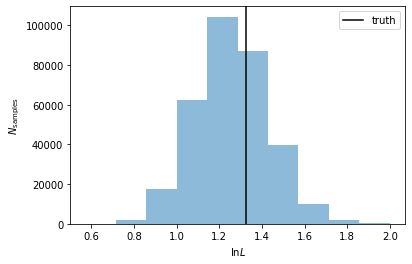

In [50]:
plt.hist(lnL_chain, alpha=0.5)
plt.axvline(np.log(L_true), c='k', label='truth')
plt.xlabel(r'$\ln L$')
plt.ylabel(r'$N_{\mathrm{samples}}$')
plt.legend()
plt.show()

Get the mean and standard deviation of our $\ln r$ samples for each source, and compare them to the true values:

In [51]:
lnr_mean = np.mean(lnr_chain, axis=0)
lnr_sigma = np.std(lnr_chain, axis=0)

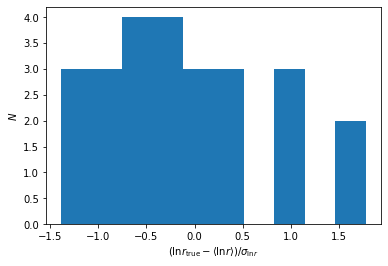

In [52]:
plt.hist((np.log(r_true)-lnr_mean)/lnr_sigma)
plt.xlabel(r'$\left( \ln r_{\mathrm{true}} - \left< \ln r \right> \right) / \sigma_{\ln r}$')
plt.ylabel(r'$N$')
plt.show()

We can make a corner plot of the samples we've generated of the model parameters, to see what the recovered distributions look like:

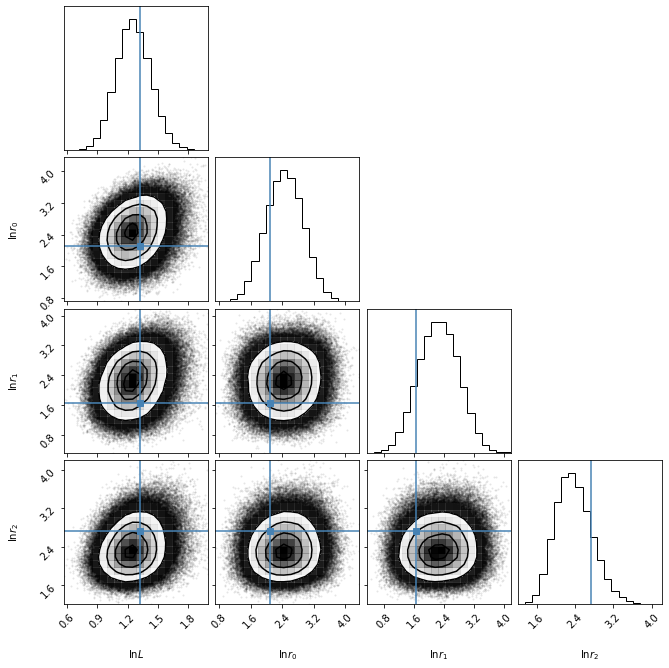

In [62]:
fig = corner.corner(
    theta_chain[:,:4], # Show only ln(L), as well as ln(r) for the first 3 sources
    labels=[r'$\ln L$']+[rf'$\ln r_{i}$' for i in range(3)],
    truths=[np.log(L_true)]+np.log(r_true[:3]).tolist()
)

Above, the contours and dots show the samples from our chain, the 1-dimensional profiles show the marginal probabilities of each of the paramters, and the blue lines represent the true parameter values.

We can get an idea of whether the chain has converged by looking at the "autocorrelation time," which is roughly the number of steps that it takes for the chain to "forget" about its previous position. This timescale is calculated for each parameter separately. If we haven't sampled at least 50 autocorrelation times, we should go back and increase the number of steps:

In [56]:
t_autocorr = sampler.get_autocorr_time()
print(t_autocorr)

[24.92341137 23.98251736 24.35867341 23.83877203 24.81084956 25.90632521
 23.97497498 25.56089334 23.44480011 24.48482575 24.47787948 24.17576926
 25.57948626 25.00959535 24.25950822 23.18662812 24.65248667 23.33645104
 23.74186021 22.99469327 24.5354071  22.56071877 24.50936542 24.90767341
 24.58416103 23.2300404 ]


In [61]:
n_autocorr_times = sampler.iteration/np.mean(t_autocorr)
print(f'Chain length: {n_autocorr_times:.1f} autocorrelation times.')

Chain length: 103.0 autocorrelation times.


When we retrieved the chain, we used `sampler.get_chain(flat=True)`. The `flat=True` option means that the chains from each of the walkers will be combined. Below, let's instead get the chain from one of the walkers, and see how it explored the parameter `ln L`:

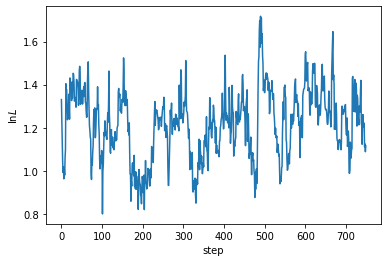

In [45]:
# sampler.get_chain() has shape (step, walker, parameter)
lnL_chain_0 = sampler.get_chain()[:,0,0]
plt.plot(lnL_chain_0)
plt.xlabel('step')
plt.ylabel(r'$\ln L$')
plt.show()

## Questions:

1. If you increase the parallax uncertainties, $\left\{ \sigma_{\varpi} \right\}$, how does the uncertainty in our inference of $\ln L$ increase? Is there a typical $\sigma_{\varpi}$ above which we would expect our inference of $L$ to degrade significantly?
2. How well does MCMC scale as we increase the number of sources? Look at the runtimes and autocorrelation times.
3. Query Gaia data on a pointing on the sky and try to estimate the scale length $L$ of the distribution of observed Milky Way stars in that direction.